# Latent Net implementation

>> Notes to the new implementation - debugging


>> - the implementation of the Fourier features is wrong. get back to that later
>> - make sure that the train function loops over the parameters that are part  of the train set (i.e. the alphas that define the training sims)
>> - the append operation
>> - plot the latent state
>> - remove the train_snaphots and test_snapshots variables
>> - for each parameter, I train always on the same positions. to be changed?

>> using more batches does not work

>> - using 1 batch of 5000 points produces interesting results. (backward ext)
>> - using 1 batch of 7e3 points learns nice on small dataset (1000 epochs, backward ext)


>> - LBFGS
>> - enlarge the networks
>> - try with 90 percent of train dataset 

>> if the backward is external, the predictions are interesting. maybe I should not accumulate the gradients of the positions, check what happens to the actual prediction (despite a different stn, the prediction is always the same in shape, and I dont see why this happens)

In [1]:
# Install PyTorch
try:
  import torch
except ImportError:
  !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
  import torch

#torch.set_default_dtype(torch.float32)

In [2]:
# Install PyG
try:
  import torch_geometric
except ImportError:
  !pip3 install torch_geometric
  import torch_geometric

In [3]:
import numpy as np
from matplotlib import pyplot as plt

In [4]:
# Import some utils from gca-rom
import sys
if 'google.colab' in str(get_ipython()):
    !git clone https://github.com/Fra-Sala/gnn_time.git
    sys.path.append('gnn_time')
else:
    sys.path.append('./..')
    
from latent_net import dynamics_network, initialization, loader, preprocessing_scale, train, plotting, testing

In [5]:
variable = 'U'
problem_name = 'lid_cavity'
print("\nProblem: ", problem_name)
print("Variable: ", variable)



Problem:  lid_cavity
Variable:  U


## Set training parameters

In [6]:
train_rate =  50         # percentage of data used for training
dim_latent = 10
epochs = 20
step_integration = 1e-1   # time step forward euler
pos_per_batch = 500
num_batches = 1
dim_solution = 2
final_time_sim = 2.0      # do not change even if you consider less snapshots (shorter simulations)
argv = [problem_name, variable, train_rate, dim_latent, step_integration, epochs, pos_per_batch, num_batches, final_time_sim, int(dim_solution)]
HyperParams = dynamics_network.HyperParams(argv)

# Initialization

In [7]:
device = initialization.set_device()
initialization.set_reproducibility(HyperParams)

Device used:  cpu


# Load dataset

In [8]:
if 'google.colab' in str(get_ipython()):
    dataset_dir = '/content/gnn_time/dataset/'+problem_name+'_unstructured.mat'
else:
    dataset_dir = '../dataset/'+problem_name+'_unstructured.mat'

# Import the data from the mat file  and get rid of the initial condition for each simulation
dataset = loader.LoadDataset(dataset_dir, variable)

def delete_initial_condition(dataset, dim):
    if dim == 1:
        dataset.U = np.delete(dataset.U, np.s_[::10], 1)
    elif dim == 2:
        indices_to_remove = list(range(0, dataset.U.shape[1], 20)) + list(range(1, dataset.U.shape[1], 20))
        dataset.U = np.delete(dataset.U, indices_to_remove, 1)
    else:
        print("Invalid dimension. Please enter 1 or 2.")
    return dataset.U

dataset.U = delete_initial_condition(dataset, HyperParams.dim)

if 'google.colab' in str(get_ipython()):
    params = np.load('/content/gnn_time/lid_driven_cavity_fenics/alpha1.npy')
else:
    params = np.load('../lid_driven_cavity_fenics/alpha1.npy')

# Array of time over which the simulations were created
time = np.linspace(0.0, 1.8, 10)

In [9]:
# DEBUG: shrink the dataset
num_sim2keep = 2 # not greater than 20, in total (train and test, before application of train_rate)
num_snap2keep = 1 # not greater than 9


def shrink_dataset(U, params, time, num_sim, num_snap_per_sim, dim):
    new_time = time[:num_snap_per_sim+1]
    new_params = params[:num_sim]
    new_U = []
    for i in range(num_sim):
        start = i * (len(time) - 1)*HyperParams.dim
        end = start + num_snap_per_sim*HyperParams.dim
        new_U.append(U[:, start:end])
 
    new_U = np.concatenate(new_U, axis=1)
    return new_U, new_time, new_params


dataset.U, time, params = shrink_dataset(dataset.U, params, time, num_sim2keep, num_snap2keep, HyperParams.dim)

time_tensor = torch.from_numpy(time)

#print("Number of simulations (series of snaps):", len(params))
#print("Number of instants of time (initial time excluded):", len(time)-1)


In [10]:
train_loader, test_loader, scaler_all,\
scaler_test, VAR_all, VAR_test, train_snapshots,\
test_snapshots, position_dataset, params_train, params_test = preprocessing_scale.process_and_scale_dataset(dataset, HyperParams, params)

Number of nodes processed:  15681
Number of simulations processed:  2


In [11]:
# data_train_iterator = iter(train_loader)
# data_train = next(data_train_iterator).to(device)
# data_train.shape


## This should be followed to scale back the data


# alpha0, alphaw = scaler_all[0], scaler_all[1]
# scaled_back_test = preprocessing_scale.inverse_normalize_input(data_test, alpha0, alphaw, np.arange(18,36,1))
# print("Scaled back trian or test dataset")
# scaled_back_test[:, 0:20, 0]



# Define the architecture

In [12]:
# DYN NN
dyn_input_size = 1 + HyperParams.dim_latent
dyn_hidden_size = 20
space_dim = 2

# REC NN
rec_input_size = space_dim + HyperParams.dim_latent#*HyperParams.batch_pos_size + HyperParams.dim_latent
rec_hidden_size = 25
rec_output_size = HyperParams.dim #HyperParams.batch_pos_size*HyperParams.dim

dyn_model = dynamics_network.DynNet(dyn_input_size, dyn_hidden_size, HyperParams.dim_latent)
rec_model = dynamics_network.RecNet(rec_input_size, rec_hidden_size, rec_output_size)
dyn_model = dyn_model.to(device)
rec_model = rec_model.to(device)

torch.set_default_dtype(torch.float32)
optimizer = torch.optim.Adam([
    {'params': dyn_model.parameters()},
    {'params': rec_model.parameters()}
], lr=HyperParams.learning_rate,  weight_decay=HyperParams.weight_decay)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=HyperParams.miles, gamma=HyperParams.gamma)


# torch.set_default_dtype(torch.float32)
# params = list(dyn_model.parameters()) + list(rec_model.parameters())
# optimizer = torch.optim.LBFGS(params, lr=HyperParams.learning_rate)

# Train the network

In [13]:
try:
    dyn_model.load_state_dict(torch.load(HyperParams.net_dir + HyperParams.net_name + '_dyn.pt'))
    rec_model.load_state_dict(torch.load(HyperParams.net_dir + HyperParams.net_name + '_rec.pt'))
    print('Loading saved network')
except:
    print('No saved network found')
    train_history, test_history = train.train_dyn_rec_nets(dyn_model, rec_model, optimizer, scheduler,\
                          device, params_train, params_test, time_tensor, train_loader, test_loader, position_dataset, HyperParams)
    plt.figure()
    plt.semilogy(train_history['loss'], label='train loss')
    plt.semilogy(test_history['loss'], label='test loss')
    plt.legend()
    plt.grid()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.savefig(HyperParams.net_dir+'loss_train_test.png', bbox_inches='tight', dpi=500)

No saved network found


  0%|          | 0/20 [00:00<?, ?it/s]

0.660403905404489
0
0.2413464056320597
1
0.21568185962042327
2
0.699935261200836
3
0.22817775519324338
4
0.2064802675887562
5
0.6818743216308555
6
0.23144598821139872
7
0.26860136290765446
8
0.23628861889919625
9
0.23477625368235774
10
0.6714260944854575
11
0.22693999003434298
12
0.2107280649581315
13
0.2217507629164064
14
0.2030441676233256
15
0.6914459248938439
16
0.23788147128788284
17
0.3136276691641894
18
0.25027328020649087
19
0.27445496680045856
20
0.26086384112109623
21
0.3081698249665572
22
0.24419250608267198
23
0.35435170011461326
24
0.22302075309341313
25
0.26980096181182994
26
0.2652356952322899
27
0.24497228154886863
28
0.22422219190488557
29
0.39222792480766416
30
0.25374393220176783
31
0.24371917356322292
32
0.2719620025884344
33
0.25269436818518026
34
0.2813285901011465
35
0.2361049668765357
36
0.26006364082230904
37
0.27862654763749267
38
0.2720841301894187
39
0.24695673745462704
40
0.235756254100218
41
0.23807712086607255
42
0.23880026134361926
43
0.2016369433707703


  5%|▌         | 1/20 [00:10<03:16, 10.36s/it, Loss(training)=0.129, Loss(test)=0.119]

0.6873497309657218
0
0.22801578389587862
1
0.203112627315579
2
0.72730935643971
3
0.21512873020587298
4
0.1930063044372028
5
0.7092798487096112
6
0.21711017877559582
7
0.2530344700978996
8
0.22242204387539516
9
0.22155619512555844
10
0.6986668789508117
11
0.21220568353084782
12
0.19768729454066677
13
0.20892358275807585
14
0.18917929822567378
15
0.718890889054378
16
0.22387998766580033
17
0.29601893978230437
18
0.23585119036364818
19
0.2589902653860228
20
0.24544279201271624
21
0.29089513717308196
22
0.2301191504757158
23
0.33713731906620237
24
0.2094179586961022
25
0.25372983092953977
26
0.2488105225604917
27
0.2309502283642863
28
0.21096091569682635
29
0.3724591841604302
30
0.23890741414377925
31
0.22915171430884457
32
0.2556900519467719
33
0.23801803484924916
34
0.2650577403307724
35
0.2225020669720596
36
0.2448906400132601
37
0.26271191355689943
38
0.2573130079181554
39
0.23302413149455517
40
0.2216594342145293
41
0.22479386732140652
42
0.22519381774356123
43
0.18759284483783348
44

 10%|█         | 2/20 [00:19<02:53,  9.66s/it, Loss(training)=0.122, Loss(test)=0.113]

0.714960084320734
0
0.21508703509119043
1
0.19090223800714448
2
0.7554184568676273
3
0.20246368957124952
4
0.1799167903840915
5
0.7373973914571926
6
0.2032016631093034
7
0.23786955851645855
8
0.20896898272031963
9
0.20873012665206492
10
0.7265989185283557
11
0.19791346905098361
12
0.18501752185867879
13
0.19646847524095054
14
0.1757127855753331
15
0.7470624371344687
16
0.21024047684040204
17
0.2789114884899524
18
0.22183971906373406
19
0.24382733652702812
20
0.23048765394351728
21
0.2740126337372533
22
0.21646637612692737
23
0.32012872732271214
24
0.19614952087748422
25
0.23819690454585624
26
0.23283916951326808
27
0.2173127525461124
28
0.19805925582814785
29
0.353324604888961
30
0.22442457374580596
31
0.21503934018505502
32
0.23978707583767478
33
0.22373640256256297
34
0.24923878371635286
35
0.20927097031355918
36
0.2301435358879234
37
0.2471607821519348
38
0.24276912950189364
39
0.21948510544847108
40
0.20786611700109792
41
0.21190880904780776
42
0.21199473264732208
43
0.173954029348

 15%|█▌        | 3/20 [00:29<02:45,  9.72s/it, Loss(training)=0.115, Loss(test)=0.107]

0.7433467708100346
0
0.20249441012267883
1
0.17906901572311232
2
0.7842619533947003
3
0.19015846189619184
4
0.167228333037666
5
0.7662789600961339
6
0.18965540134821632
7
0.22308070134036373
8
0.1958641276556399
9
0.19625254176207868
10
0.7553038354476725
11
0.1839987868314853
12
0.1727372691944846
13
0.18438284236074556
14
0.16265779536532454
15
0.7759848283360834
16
0.19695027706992618
17
0.2622838357972067
18
0.20820628661356227
19
0.22892953469093816
20
0.21596620470537534
21
0.257492136579795
22
0.20318685499698932
23
0.3032540731942454
24
0.18320738839903036
25
0.2231781077248806
26
0.21729339621425084
27
0.20403927927108728
28
0.1855185984243862
29
0.3348283526511748
30
0.210273159053859
31
0.20133711853776382
32
0.22422328567608785
33
0.20982527470562778
34
0.23384514229128142
35
0.19640243382720934
36
0.2157931282145365
37
0.2319445388529943
38
0.2283962505418607
39
0.2063092287181305
40
0.19435216941063765
41
0.19936613357352248
42
0.1991375248708838
43
0.16073159849422214
44

 20%|██        | 4/20 [00:39<02:35,  9.74s/it, Loss(training)=0.109, Loss(test)=0.101]

0.7725898539888711
0
0.1901903789018551
1
0.16755471907099995
2
0.813947374239767
3
0.1781591860858811
4
0.154898368728727
5
0.7960184479599516
6
0.17643866420590723
7
0.208624385815295
8
0.18306706518109586
9
0.18407248933428078
10
0.7848686403189976
11
0.17043677958240008
12
0.16079570270796548
13
0.1726104147064477
14
0.14998049227872523
15
0.8057588004963695
16
0.18396471850787638
17
0.2460818648143397
18
0.19490081372814147
19
0.21427368497851657
20
0.20182766528131757
21
0.24129730093922153
22
0.19023127989729827
23
0.286509559382336
24
0.1705548639721115
25
0.20861668632819164
26
0.20213877576614042
27
0.1910788584763745
28
0.17328864856720963
29
0.3168943816929892
30
0.1964161025875799
31
0.18799636732693095
32
0.20897403666023442
33
0.19623775360664553
34
0.21882821041116313
35
0.18384429373218397
36
0.2017912079692094
37
0.21702777623330965
38
0.2141897665317945
39
0.1934441339022373
40
0.18109268709601078
41
0.18711653817958232
42
0.18657812930036297
43
0.14789610573648518
4

 25%|██▌       | 5/20 [00:48<02:24,  9.63s/it, Loss(training)=0.102, Loss(test)=0.0951]

0.8027542789349111
0
0.17814011629914936
1
0.1562980963356975
2
0.8446049481263311
3
0.16641724128794771
4
0.14288645250768697
5
0.8267145356991699
6
0.16353591041065896
7
0.1944668660440808
8
0.17055269079470733
9
0.1721481896592025
10
0.8153752003855856
11
0.15722066630019216
12
0.1491418601209192
13
0.16109603008578458
14
0.13765048257327006
15
0.8364992865015146
16
0.17124412018476856
17
0.23026586865611323
18
0.1818829894450744
19
0.19984407811170313
20
0.1880346854770349
21
0.22540214153396432
22
0.17756246244385726
23
0.2698994968094338
24
0.1581590839919279
25
0.19447201918673063
26
0.1873536791391664
27
0.17838675572055304
28
0.1613206907511565
29
0.2994645656540973
30
0.18282342140065855
31
0.174982749172815
32
0.19402335192809467
33
0.182935328403829
34
0.20415175159619584
35
0.1715478460816933
36
0.18810047738202434
37
0.2023838556818433
38
0.20015253853432138
39
0.1808450745115069
40
0.1680684531391431
41
0.17512171836166496
42
0.17428655550785296
43
0.13542181979438805
44

 30%|███       | 6/20 [00:58<02:17,  9.85s/it, Loss(training)=0.0963, Loss(test)=0.0894]

0.8339287355996583
0
0.1663207229926641
1
0.14526346568809345
2
0.87636866070289
3
0.15490322408922033
4
0.1311699058691569
5
0.8584805546888717
6
0.1509357984969309
7
0.1805860480438752
8
0.1583038914226544
9
0.16045350736509675
10
0.8469248483518177
11
0.14434443058143817
12
0.13774647810004276
13
0.14980707526666778
14
0.1256513872838935
15
0.8683305939583894
16
0.15876591381309652
17
0.21480236373807318
18
0.16912662072863172
19
0.18563641294642963
20
0.17455957804481023
21
0.20978854332853866
22
0.16515558048233142
23
0.2534368851500522
24
0.1460041435868636
25
0.1807100807760174
26
0.17292072948897952
27
0.16593561397322426
28
0.14958688986912733
29
0.28248341193199006
30
0.1694788329073439
31
0.16227150812730332
32
0.1793628638430515
33
0.16989382510557638
34
0.18978872221881485
35
0.15948420439691874
36
0.17469553283106884
37
0.18799719803647183
38
0.18629804211642584
39
0.1684840467559442
40
0.15527413999563133
41
0.16335716619226281
42
0.16224276842030771
43
0.123295284410988

 35%|███▌      | 7/20 [01:08<02:09,  9.93s/it, Loss(training)=0.0903, Loss(test)=0.0839]

0.8662222669626833
0
0.15471528958895475
1
0.1344314206480605
2
0.9093742694607869
3
0.14359908088623183
4
0.11973875287672024
5
0.8914411337360746
6
0.138629991215876
7
0.16696808889574222
8
0.14630799091908525
9
0.14897099167516353
10
0.8796348745944329
11
0.13180388044208918
12
0.12659475967114778
13
0.13872484039216645
14
0.11397797560999487
15
0.901383550383219
16
0.14651884212073382
17
0.19966279811564333
18
0.15661418233049798
19
0.1716554280138774
20
0.16138094148602455
21
0.1944453906833248
22
0.15299287383987292
23
0.23714298440327858
24
0.13408583873786556
25
0.16730122228766647
26
0.1588274546113671
27
0.153708897931218
28
0.13807287861387704
29
0.2658975972999341
30
0.1563757957192369
31
0.14984359165466343
32
0.16499174293567284
33
0.15709844479996
34
0.17571869563446602
35
0.14763694464467916
36
0.16155880528899985
37
0.17386070448589552
38
0.17264859977240282
39
0.15634302714790654
40
0.142714678230473
41
0.15180570942508864
42
0.1504319406683662
43
0.11151353243265243


 40%|████      | 8/20 [01:19<02:01, 10.09s/it, Loss(training)=0.0845, Loss(test)=0.0785]

0.8997556669936435
0
0.143312650790228
1
0.12379240175889285
2
0.9437597679605068
3
0.13249466568111365
4
0.1085922668224749
5
0.9257280282775905
6
0.12661569539349984
7
0.15360686047522365
8
0.13455798467213811
9
0.1376900320057735
10
0.9136320856000905
11
0.11960022561485144
12
0.11568148459225046
13
0.1278395330958712
14
0.1026339365496117
15
0.935793654993729
16
0.134500182872993
17
0.18482529567736847
18
0.14433552104468864
19
0.1579140308097498
20
0.14848413652253228
21
0.17936919713531255
22
0.14106314649524054
23
0.22104705217086082
24
0.12240874205463745
25
0.15422192308559618
26
0.14506825148566718
27
0.14169819117512059
28
0.12677338665714077
29
0.2496594977079036
30
0.14351600844813808
31
0.13768623081068554
32
0.15091701264313506
33
0.14454224896166679
34
0.1619283945266011
35
0.1359983102900247
36
0.1486800789263956
37
0.1599752444879226
38
0.1592345326406907
39
0.1444116276930233
40
0.13040342367050034
41
0.1404564696038174
42
0.1388449616798924
43
0.10008236623803939
44

 45%|████▌     | 9/20 [01:30<01:54, 10.44s/it, Loss(training)=0.0788, Loss(test)=0.0733]

0.9346545440641811
0
0.13210765586334902
1
0.11334369046429724
2
0.9796624664101771
3
0.12158634143991275
4
0.09773771986702115
5
0.961475191010897
6
0.11489767258658261
7
0.1405043949671949
8
0.12305371770688314
9
0.126606298069997
10
0.9490468555481157
11
0.10774280112054328
12
0.10500888951639685
13
0.11714805680632451
14
0.09163143089996302
15
0.9716971685402281
16
0.12271512568430841
17
0.1702751275317845
18
0.13228758201460222
19
0.14443510982079705
20
0.13586148042757662
21
0.16456566144515938
22
0.1293618234395603
23
0.20519053064584614
24
0.11098585957041926
25
0.1414547333755422
26
0.1316459288996414
27
0.12990232031707147
28
0.11569056006736948
29
0.23372641749574874
30
0.13090985413885128
31
0.12579330165135924
32
0.13715546998069797
33
0.1322259810987104
34
0.14841214354728763
35
0.12456777260690916
36
0.13605660428773872
37
0.14635074688664984
38
0.14609725859326916
39
0.13268631792326008
40
0.11836311920936962
41
0.12930471984338923
42
0.12747916803149184
43
0.0890162727

 45%|████▌     | 9/20 [01:38<02:00, 11.00s/it, Loss(training)=0.0788, Loss(test)=0.0733]


KeyboardInterrupt: 

# Test the model over the test set

In [ ]:
from latent_net import plotting, testing
PARAMS = np.repeat(params, len(time)-1, axis=0)
TIMES = np.tile(time[1:], params.shape[0])
# concatenate TIMES and params_test as two columns
#np.random.shuffle(test_snapshots)
snapshots = test_snapshots


# the rescaling is correct, and the predictions are qualitatively correct
#rescaled_results = preprocessing_scale.inverse_normalize_input(results, scaler_all, snapshots)




# Plot the results

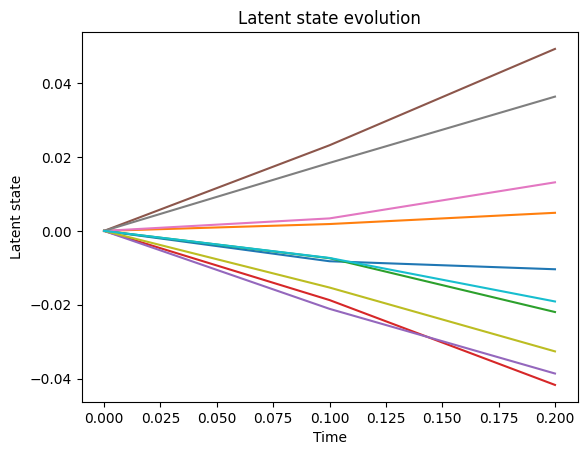

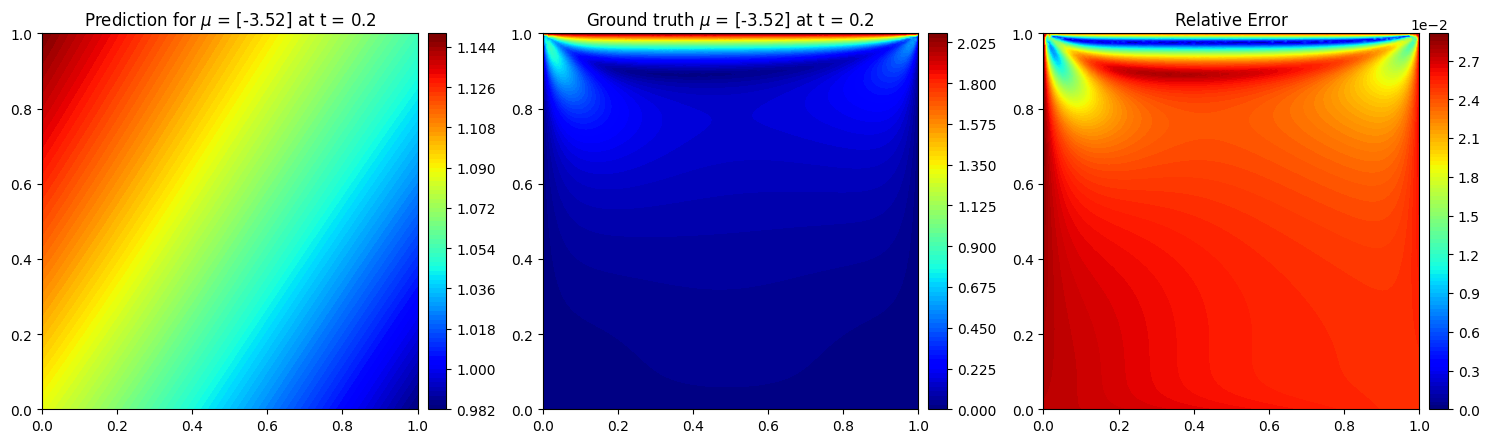

In [ ]:
num_pos_requests = len(position_dataset)//HyperParams.batch_pos_size
for i,SNAP in enumerate(snapshots):
    
    Z_net, stn_evolution, time_evolution = testing.test(dyn_model, rec_model, device, PARAMS[SNAP], TIMES[SNAP], position_dataset, num_pos_requests, HyperParams)

    plotting.plot_latent(stn_evolution, time_evolution, SNAP, HyperParams)
        
    plotting.plot_fields(SNAP, Z_net, scaler_all, HyperParams, dataset, PARAMS, TIMES)


In [ ]:
# num_iterations = len(position_dataset)//HyperParams.batch_pos_size

# for i,SNAP in enumerate(snapshots):
#     Z_net = torch.zeros((len(position_dataset), HyperParams.dim))
#     for j in range(num_iterations):
#         pos_test = position_dataset[j*HyperParams.batch_pos_size:(j+1)*HyperParams.batch_pos_size]
#         result, stn_evolution, time_evolution = testing.test(dyn_model, rec_model, device, PARAMS[SNAP], TIMES[SNAP], pos_test, HyperParams)
#         if HyperParams.dim == 1:
#             Z_net[j*HyperParams.batch_pos_size:(j+1)*HyperParams.batch_pos_size, 0] = result
#         if HyperParams.dim == 2:
#             Z_net[j*HyperParams.batch_pos_size:(j+1)*HyperParams.batch_pos_size, 0] = result[:len(result) // 2]
#             Z_net[j*HyperParams.batch_pos_size:(j+1)*HyperParams.batch_pos_size, 1] = result[len(result) // 2:]
     

#     plotting.plot_latent(stn_evolution, time_evolution)
    
#     plotting.plot_fields(SNAP, Z_net, scaler_all, HyperParams, dataset, PARAMS, TIMES)
#     i+1

In [ ]:
position_dataset[0:20, 0]

tensor([-1.0000, -1.0000,  1.0000,  1.0000,  0.0000,  1.0000,  0.0000, -1.0000,
         0.0000, -1.0000, -0.5000, -0.5000, -1.0000,  1.0000,  0.5000,  1.0000,
         0.5000,  0.4167, -0.4167, -0.2500], dtype=torch.float64)

In [ ]:
dataset.xx[0:20, 0]

tensor([0.0000, 0.0000, 1.0000, 1.0000, 0.5000, 1.0000, 0.5000, 0.0000, 0.5000,
        0.0000, 0.2500, 0.2500, 0.0000, 1.0000, 0.7500, 1.0000, 0.7500, 0.7083,
        0.2917, 0.3750], dtype=torch.float64)